In [1]:
import numpy as np
import pandas as pd

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from sklearn import datasets

import tensorflow as tf
from tensorflow.keras import Input, Model, layers, losses, optimizers

from matplotlib import pyplot as plt

**Differential Privacy**

The goal of differential privacy is to minimize the effect, a single training sample can have of the output of a (randomized) algorithm. Therefore, perform the following tasks:
1) Load the boston housing dataset, one-hot encode the categorical features and normalize (use StandardScaler) the continuous features.

2) Split the data into train/test (80% / 20%) sets (give a seed for reproducibility, i.e. random_state=42).

3) Train a LinearRegression model (set fit_intercept=False) on the training set and compute r2_score and mean_squared_error on the test set.

4) Find the training sample with the largest prediction error. Create a mask to exclude that **sample** from the training set.

5) Fit the same LinearRegression model to the training set excluding the found **sample**. Measure the deviation of the two regression models (e.g. np.linalg.norm(w-w'), the weights w can be found in LinearRegression.coef_)

6) Add noise of varying scales to the training set, create a second training set by excluding the **sample** and train linear regression models on each. How does the utility (r2_score, mse) behave with increasing noise level? What happens to the difference between the fitted models' weights? What about the prediction error on the **sample**? Plot the r2_score, mse, prediction error on **sample** and weight difference over the noise scale.




In [3]:
# load dataset
boston_dataset = datasets.load_boston()
X = pd.DataFrame(boston_dataset.data, columns=boston_dataset.feature_names)
Y = pd.DataFrame(boston_dataset.target, columns=['price'])

# normalize continuous features
cont_features = ['CRIM', 'ZN', 'INDUS', 'NOX', 'RM', 'AGE', 'DIS', 'TAX', 'PTRATIO', 'B', 'LSTAT']
feature_scaler = StandardScaler()
X_pp = X.copy()
X_pp[cont_features] = feature_scaler.fit_transform(X[cont_features])
print(X_pp.head())

# normalize targets
Y_pp = Y.copy()
target_scaler = StandardScaler()
Y_pp[['price']] = target_scaler.fit_transform(Y[['price']])

# one-hot-encode the 'RAD' feature
X_pp[['CHAS', 'RAD']] = X_pp[['CHAS', 'RAD']].astype('int32')
X_pp = pd.get_dummies(X_pp, columns=['RAD'])
print(X_pp.head())

# split data and target DataFrames into data train, data test, target train and target test datasets
X_train, X_test, Y_train, Y_test = train_test_split(X_pp.to_numpy(), Y_pp.to_numpy(), test_size=0.20, random_state=42)

       CRIM        ZN     INDUS  CHAS       NOX        RM       AGE       DIS  \
0 -0.419782  0.284830 -1.287909   0.0 -0.144217  0.413672 -0.120013  0.140214   
1 -0.417339 -0.487722 -0.593381   0.0 -0.740262  0.194274  0.367166  0.557160   
2 -0.417342 -0.487722 -0.593381   0.0 -0.740262  1.282714 -0.265812  0.557160   
3 -0.416750 -0.487722 -1.306878   0.0 -0.835284  1.016303 -0.809889  1.077737   
4 -0.412482 -0.487722 -1.306878   0.0 -0.835284  1.228577 -0.511180  1.077737   

   RAD       TAX   PTRATIO         B     LSTAT  
0  1.0 -0.666608 -1.459000  0.441052 -1.075562  
1  2.0 -0.987329 -0.303094  0.441052 -0.492439  
2  2.0 -0.987329 -0.303094  0.396427 -1.208727  
3  3.0 -1.106115  0.113032  0.416163 -1.361517  
4  3.0 -1.106115  0.113032  0.441052 -1.026501  
       CRIM        ZN     INDUS  CHAS       NOX        RM       AGE       DIS  \
0 -0.419782  0.284830 -1.287909     0 -0.144217  0.413672 -0.120013  0.140214   
1 -0.417339 -0.487722 -0.593381     0 -0.740262  0.194274

/opt/conda/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function load_boston is deprecated; `load_boston` is deprecated in 1.0 and will be removed in 1.2.

    The Boston housing prices dataset has an ethical problem. You can refer to
    the documentation of this function for further details.

    The scikit-learn maintainers therefore strongly discourage the use of this
    dataset unless the purpose of the code is to study and educate about
    ethical issues in data science and machine learning.

    In this special case, you can fetch the dataset from the original
    source::

        import pandas as pd
        import numpy as np


        data_url = "http://lib.stat.cmu.edu/datasets/boston"
        raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
        data = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
        target = raw_df.values[1::2, 2]

    Alternative datasets include the California housing dataset (i.e.

In [4]:
# train regression model and find sample with largest prediction error
LR = LinearRegression(fit_intercept=False)
LR.fit(X_train, Y_train)

y_pred = LR.predict(X_test)
mse = mean_squared_error(Y_test, y_pred)
r2 = r2_score(Y_test, y_pred)
print("Model coefficients on parent database")
print("-------------------------------------")
print(f'Mean Squared Error {mse}')
print(f"r2 score {r2}")
# create neighboring dataset, i.e. training set without the sample with largest prediction error

y_train_pred = LR.predict(X_train)
outlier_row = np.argmax(np.abs(y_train_pred - Y_train))
print()
print("Size of parent database")
print("-----------------------")
print(X_train.shape, Y_train.shape)

X_train = np.delete(X_train,outlier_row,0)
Y_train = np.delete(Y_train,outlier_row,0)
print()
print("Size of neighbouring database")
print("-----------------------------")
print(X_train.shape, Y_train.shape)
# train on that dataset the same model, measure the difference between both models' coefficients
LR.fit(X_train, Y_train)

y_pred = LR.predict(X_test)
mse = mean_squared_error(Y_test, y_pred)
r2 = r2_score(Y_test, y_pred)
print()
print("Model coefficients on Neighbouring database")
print("-------------------------------------------")
print(f'Mean Squared Error {mse}')
print(f"r2 score {r2}")

Model coefficients on parent database
-------------------------------------
Mean Squared Error 0.29398925875149384
r2 score 0.6615687658684821

Size of parent database
-----------------------
(404, 21) (404, 1)

Size of neighbouring database
-----------------------------
(403, 21) (403, 1)

Model coefficients on Neighbouring database
-------------------------------------------
Mean Squared Error 0.30507232217602603
r2 score 0.648810290104261


In [4]:
# train on varying noise scales, you should repeat the computation for each sigma several times and average
sigmas = np.logspace(-3,2, 24) # noise scales




In [5]:
# plot results


**Autoencoder**

An autoencoder is a model that maps samples into a so-called latent space and then back to the original space. It consists of an encoder model X->Z and a decoder model Z->X. 
It is used for dimensionality reduction, representation learning and as generative model. The training objective of an autoencoder is usually a combination of reconstruction error and some regularization (on its weights and/or the latent representation).

1) Load the mnist dataset, split into 10k training samples and 1000 test samples. Take 1000 training samples for evaluation.

2) Build a linear autoencoder (encoder/decoder are linear models each). Train your autoencoder with 2D latent space Z. 

3) Visualize the results as follows: For 1000 training and 1000 test samples

    a) Create a scatterplot of the latent embeddings
    
    b) Plot the reconstructions of 100 samples in a 10x10 grid
    
    c) Plot the corresponding original samples below
    
3) Build a non-linear autoencoder. The encoder has 2 conv layers (32/64 filters of size (3,3), strides 2), followed by a dense layer that maps to 2-dimensional latent variables. The decoder consists of a dense layer, followed by 2 conv-transpose layers (64/32, ... matching the encoder). Train the non-linear autoencoder and visualize the results as above.

4) Create synthetic samples by randomly sampling 100 points in latent space and decoding them using the linear and non-linear decoders.


In [2]:
# load data
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

X = x_train.astype('float32').reshape((-1, 28,28,1))/255.
Xtrain, Xtest_, Ytrain, Ytest_ = train_test_split(X, y_train, train_size=10000)
Xtest, Xtest_, Ytest, Ytest_ = train_test_split(Xtest_, Ytest_, train_size=1000)

Xtrain_, _, Ytrain_, _ = train_test_split(Xtrain, Ytrain, train_size=1000)

11501568/11490434 [==============================] - 1s 0us/step


In [3]:
# helper function to plot several samples in one image
def make_grid(X, grid_size=[10,10]):
    sh = [X.shape[1], X.shape[2]]
    G = np.zeros((sh[0]*grid_size[0], sh[1]*grid_size[1]))
    for i in range(grid_size[0]):
        for j in range(grid_size[1]):
            G[i*sh[0]:(i+1)*sh[0], j*sh[1]:(j+1)*sh[1]] = X[i*grid_size[1]+j].reshape(sh)
    return G

In [4]:
# define autoencoder model
class AutoEncoder(Model):
    
    def __init__(self, encoder, decoder, **kwargs):
        super(AutoEncoder, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        
    def call(self, X, training=None):
        z = self.encoder(X)
        x = self.decoder(z)
        return x    

In [5]:
# linear models
l = Xtrain.shape[1]
h = Xtrain.shape[2]
latent_dim = 2
encoder = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(latent_dim, input_shape=[l*h], activation='relu'),
])

decoder = tf.keras.models.Sequential([
    tf.keras.layers.Dense(l*h, input_shape=[latent_dim], activation='sigmoid'),
    tf.keras.layers.Reshape((l, h)),
])

linear_autoencoder = AutoEncoder(encoder, decoder)
linear_autoencoder.compile(optimizer='adam', loss=losses.MeanSquaredError())

2022-11-29 16:38:08.830483: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [6]:
# train linear autoencoder
History = linear_autoencoder.fit(Xtrain, Xtrain,
                epochs=50,
                shuffle=True,
                validation_data=(Xtest, Xtest))

2022-11-29 16:38:15.833558: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/50
313/313 [==============================] - 2s 4ms/step - loss: 0.1017 - val_loss: 0.0708
Epoch 2/50
313/313 [==============================] - 1s 3ms/step - loss: 0.0673 - val_loss: 0.0647
Epoch 3/50
313/313 [==============================] - 1s 3ms/step - loss: 0.0630 - val_loss: 0.0627
Epoch 4/50
313/313 [==============================] - 1s 3ms/step - loss: 0.0617 - val_loss: 0.0618
Epoch 5/50
313/313 [==============================] - 1s 3ms/step - loss: 0.0609 - val_loss: 0.0610
Epoch 6/50
313/313 [==============================] - 1s 3ms/step - loss: 0.0602 - val_loss: 0.0605
Epoch 7/50
313/313 [==============================] - 1s 3ms/step - loss: 0.0597 - val_loss: 0.0599
Epoch 8/50
313/313 [==============================] - 1s 3ms/step - loss: 0.0592 - val_loss: 0.0594
Epoch 9/50
313/313 [==============================] - 1s 3ms/step - loss: 0.0588 - val_loss: 0.0591
Epoch 10/50
313/313 [==============================] - 1s 3ms/step - loss: 0.0584 - val_loss: 0.0587

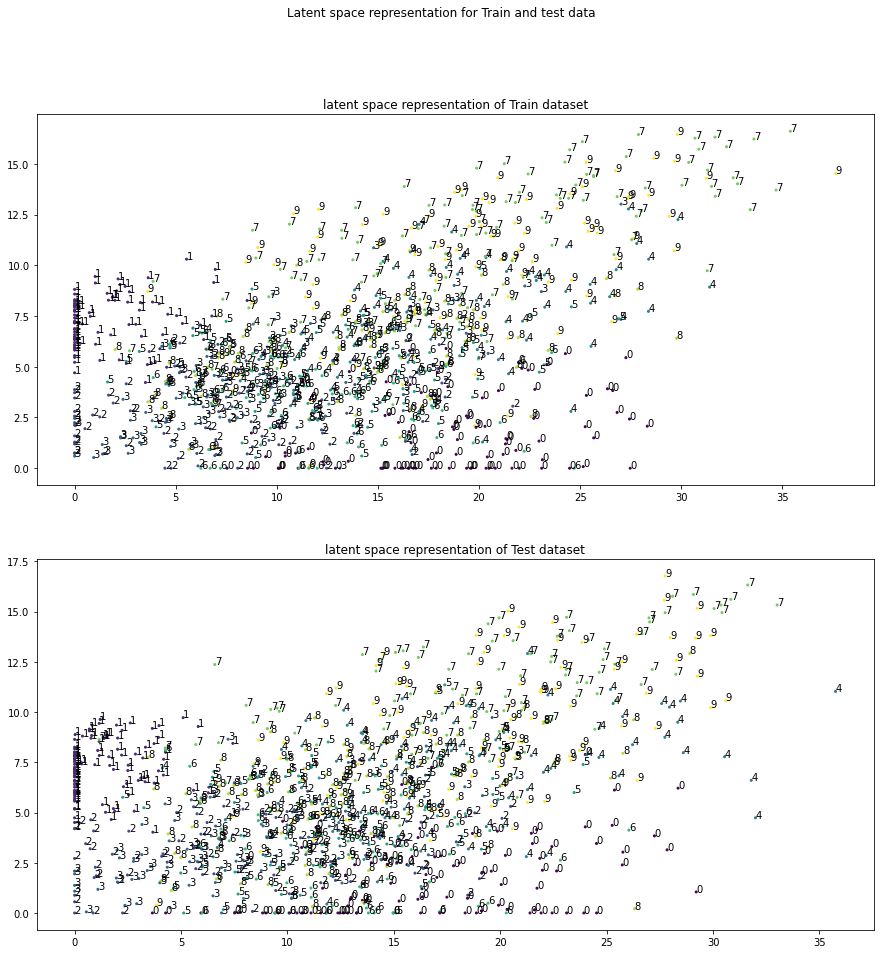

In [28]:
# visualize latent space
fig, axs = plt.subplots(2, figsize=(15,15))
fig.suptitle('Latent space representation for Train and test data')

train_latent_space = linear_autoencoder.encoder.predict(Xtrain[:1000])
axs[0].scatter(train_latent_space[:,0], train_latent_space[:,1], marker='o', s=4, c=Ytrain[0:1000])
axs[0].set_title("latent space representation of Train dataset")
for i, txt in enumerate(Ytrain[:1000]):
    axs[0].annotate(txt, (train_latent_space[i,0], train_latent_space[i,1]))
    
test_latent_space = linear_autoencoder.encoder.predict(Xtest)
axs[1].scatter(test_latent_space[:,0], test_latent_space[:,1], marker='o', s=4, c=Ytest)
for i, txt in enumerate(Ytest):
    axs[1].annotate(txt, (test_latent_space[i,0], test_latent_space[i,1]))
axs[1].set_title("latent space representation of Test dataset")
plt.show()

Text(0.5, 1.0, 'Reconstructed test images')

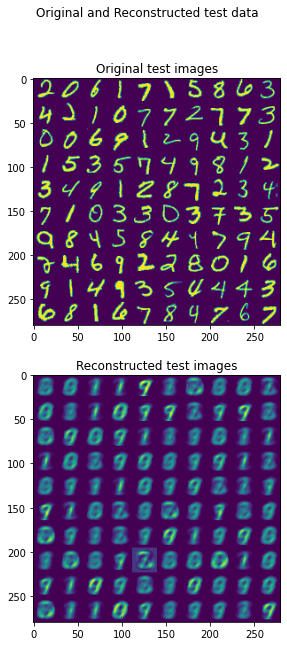

In [30]:
# visualize reconstructions and original samples for test data

original = make_grid(Xtest[:100])

decoded_imgs = linear_autoencoder.call(Xtest).numpy()
reconstructed = make_grid(decoded_imgs[:100])

fig, axs = plt.subplots(2, figsize=(10,10))
fig.suptitle('Original and Reconstructed test data')
axs[0].imshow(original)
axs[0].set_title('Original test images')
axs[1].imshow(reconstructed)
axs[1].set_title('Reconstructed test images')

Text(0.5, 1.0, 'Reconstructed train images')

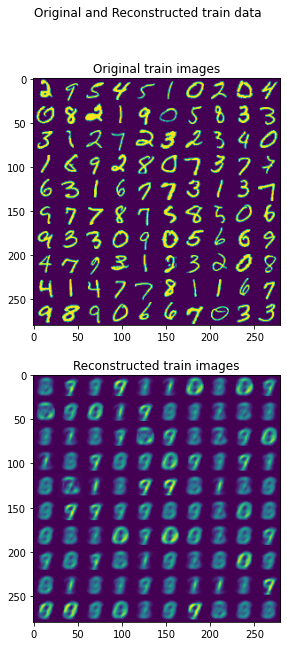

In [31]:
# visualize reconstructions and original samples for train data
original = make_grid(Xtrain[:100])

decoded_imgs = linear_autoencoder.call(Xtrain).numpy()
reconstructed = make_grid(decoded_imgs[:100])

fig, axs = plt.subplots(2, figsize=(10,10))
fig.suptitle('Original and Reconstructed train data')
axs[0].imshow(original)
axs[0].set_title('Original train images')
axs[1].imshow(reconstructed)
axs[1].set_title('Reconstructed train images')

In [42]:
# train non-linear autoencoder
l = Xtrain.shape[1]
h = Xtrain.shape[2]
latent_dim = 2

encoder = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation="relu", padding="same",strides=2),
    tf.keras.layers.Conv2D(64, (3, 3), activation="relu", padding="same",strides=2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(latent_dim, activation='relu'),
])
    
decoder = tf.keras.models.Sequential([
    tf.keras.layers.Dense(7 * 7 * 64, activation="relu"),
    tf.keras.layers.Reshape((7, 7, 64)),
    tf.keras.layers.Conv2DTranspose(64, (3, 3), activation="relu", padding="same",strides=2),
    tf.keras.layers.Conv2DTranspose(32, (3, 3), activation="relu", padding="same",strides=2),
    tf.keras.layers.Conv2D(1, (3, 3), activation="sigmoid", padding="same"),
])

non_linear_autoencoder = AutoEncoder(encoder, decoder)
non_linear_autoencoder.compile(optimizer='adam', loss=losses.MeanSquaredError())
non_linear_autoencoder.build((None,28,28,1))
non_linear_autoencoder.summary()

Model: "auto_encoder_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_20 (Sequential)   (None, 2)                 25090     
_________________________________________________________________
sequential_21 (Sequential)   (None, 28, 28, 1)         65089     
Total params: 90,179
Trainable params: 90,179
Non-trainable params: 0
_________________________________________________________________


In [43]:
# train linear autoencoder
History = non_linear_autoencoder.fit(Xtrain, Xtrain,
                epochs=50,
                shuffle=True,
                validation_data=(Xtest, Xtest))

Epoch 1/50
313/313 [==============================] - 11s 33ms/step - loss: 0.0754 - val_loss: 0.0571
Epoch 2/50
313/313 [==============================] - 10s 33ms/step - loss: 0.0540 - val_loss: 0.0531
Epoch 3/50
313/313 [==============================] - 11s 35ms/step - loss: 0.0515 - val_loss: 0.0513
Epoch 4/50
313/313 [==============================] - 10s 33ms/step - loss: 0.0500 - val_loss: 0.0502
Epoch 5/50
313/313 [==============================] - 10s 32ms/step - loss: 0.0488 - val_loss: 0.0491
Epoch 6/50
313/313 [==============================] - 11s 35ms/step - loss: 0.0478 - val_loss: 0.0482
Epoch 7/50
313/313 [==============================] - 11s 35ms/step - loss: 0.0470 - val_loss: 0.0476
Epoch 8/50
313/313 [==============================] - 10s 33ms/step - loss: 0.0462 - val_loss: 0.0469
Epoch 9/50
313/313 [==============================] - 11s 35ms/step - loss: 0.0456 - val_loss: 0.0460
Epoch 10/50
313/313 [==============================] - 10s 32ms/step - loss: 0.045

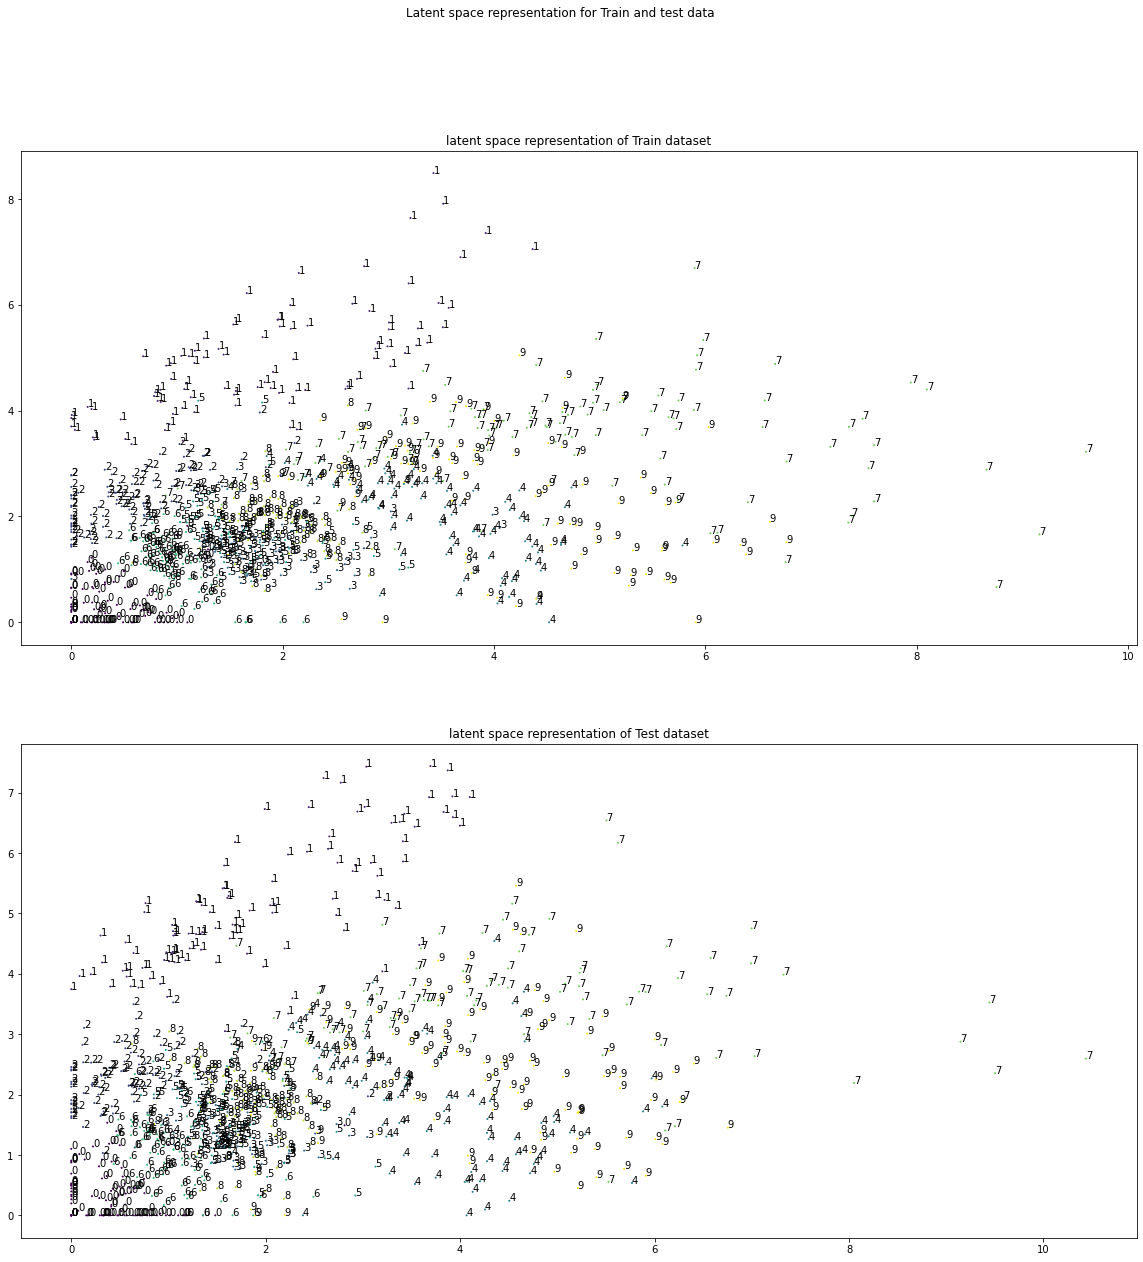

In [45]:
# Visualization as before for non-linear model
# visualize latent space
fig, axs = plt.subplots(2, figsize=(20,20))
fig.suptitle('Latent space representation for Train and test data')

train_latent_space = non_linear_autoencoder.encoder.predict(Xtrain[:1000])
axs[0].scatter(train_latent_space[:,0], train_latent_space[:,1], marker='o', s=1, c=Ytrain[:1000])
axs[0].set_title("latent space representation of Train dataset")
for i, txt in enumerate(Ytrain[:1000]):
    axs[0].annotate(txt, (train_latent_space[i,0], train_latent_space[i,1]))

test_latent_space = non_linear_autoencoder.encoder.predict(Xtest)
axs[1].scatter(test_latent_space[:,0], test_latent_space[:,1], marker='o', s=1, c=Ytest[:1000])
for i, txt in enumerate(Ytest):
    axs[1].annotate(txt, (test_latent_space[i,0], test_latent_space[i,1]))
axs[1].set_title("latent space representation of Test dataset")
plt.show()

Text(0.5, 1.0, 'Reconstructed test images')

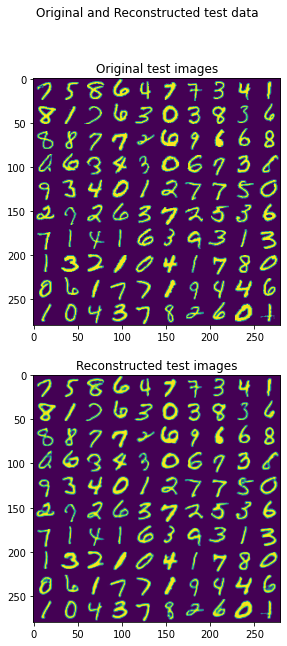

In [19]:
# visualize reconstructions and original samples for test data

original = make_grid(Xtest[:100])

decoded_imgs = non_linear_autoencoder.call(Xtest).numpy()
reconstructed = make_grid(decoded_imgs[:100])

fig, axs = plt.subplots(2, figsize=(10,10))
fig.suptitle('Original and Reconstructed test data')
axs[0].imshow(original)
axs[0].set_title('Original test images')
axs[1].imshow(reconstructed)
axs[1].set_title('Reconstructed test images')

Text(0.5, 1.0, 'Reconstructed train images')

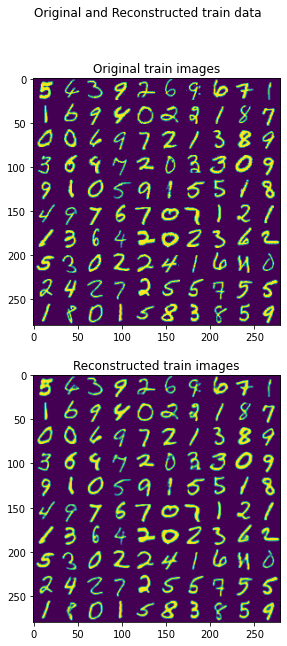

In [20]:
# visualize reconstructions and original samples for train data
original = make_grid(Xtrain[:100])

decoded_imgs = non_linear_autoencoder.call(Xtrain).numpy()
reconstructed = make_grid(decoded_imgs[:100])

fig, axs = plt.subplots(2, figsize=(10,10))
fig.suptitle('Original and Reconstructed train data')
axs[0].imshow(original)
axs[0].set_title('Original train images')
axs[1].imshow(reconstructed)
axs[1].set_title('Reconstructed train images')

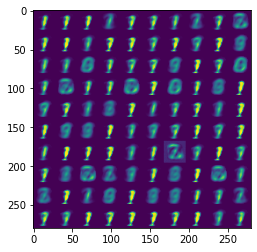

In [58]:
# Try out linear decoder as generative model
x = np.array([np.random.uniform(0.0, 17.0, 100)])
y = np.array([np.random.uniform(0.0, 35.0, 100)])

encoded_sample = np.concatenate((x.T,y.T), axis=1)
#print(encoded_sample)
synthetic_data_for_linear_decoder = linear_autoencoder.decoder(encoded_sample)

synthetic_data_for_linear_decoder = np.array(synthetic_data_for_linear_decoder)
synthetic_data_for_linear_decoder = np.reshape(synthetic_data_for_linear_decoder, (synthetic_data_for_linear_decoder.shape[0], synthetic_data_for_linear_decoder.shape[1], synthetic_data_for_linear_decoder.shape[2], 1 ))
generated_digits_from_linear_decoder = make_grid(synthetic_data_for_linear_decoder)

plt.imshow(generated_digits_from_linear_decoder)

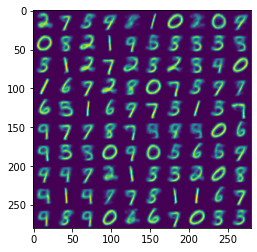

In [56]:
# Non-linear decoder as generative model

x = np.array([np.random.uniform(0.0, 10.0, 100)])
y = np.array([np.random.uniform(0.0, 10.0, 100)])

encoded_sample = np.concatenate((x.T,y.T), axis=1)
synthetic_data_for_non_linear_decoder = non_linear_autoencoder.decoder(train_latent_space[:100])

synthetic_data_for_non_linear_decoder = np.array(synthetic_data_for_non_linear_decoder)
synthetic_data_for_non_linear_decoder = np.reshape(synthetic_data_for_non_linear_decoder, (synthetic_data_for_non_linear_decoder.shape[0], synthetic_data_for_non_linear_decoder.shape[1], synthetic_data_for_non_linear_decoder.shape[2], 1 ))
generated_digits_from_non_linear_decoder = make_grid(synthetic_data_for_non_linear_decoder)

plt.imshow(generated_digits_from_non_linear_decoder)